# **Import Library dan Install Dependensi**

In [1]:
!pip install tensorflow -q

In [2]:
!pip install mtcnn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.6 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Library untuk manipulasi data dan analisis numerik
import pandas as pd
import numpy as np

# Library untuk plotting dan visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns

# Library untuk pengolahan dan manipulasi gambar
import cv2
from PIL import Image

# Library untuk operasi sistem, manipulasi file dan direktori, serta handling file zip
import zipfile
import os
import shutil
import random

# Library untuk clustering, contoh K-Means clustering
from sklearn.cluster import KMeans

# Library untuk augmentasi dan preprocessing gambar pada deep learning dengan Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Library untuk mengabaikan peringatan agar output lebih bersih
import warnings
warnings.filterwarnings('ignore')

# Library untuk progress bar saat iterasi panjang
from tqdm import tqdm

# Library untuk deteksi wajah dengan MTCNN (Multi-task Cascaded Convolutional Networks)
from mtcnn.mtcnn import MTCNN

# **Load Dataset**

In [5]:
# Path ke file ZIP
zip_path = "./drive/MyDrive/dataset-hijabist/hijabist-skin-tone.zip"
extract_path = "./datasets"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  print(f"Mengekstrak {zip_path} ke {extract_path}...")
  zip_ref.extractall(extract_path)
  print("Ekstraksi selesai.")

Mengekstrak ./drive/MyDrive/dataset-hijabist/hijabist-skin-tone.zip ke ./datasets...
Ekstraksi selesai.


In [6]:
# Cek isi folder 'data_skintone'
skintone_subfolder = './datasets'
print("\nIsi dalam data_skintone:")
print(os.listdir(skintone_subfolder))


Isi dalam data_skintone:
['mid-dark', 'mid-light', 'light', 'dark']


Distribusi jumlah gambar per kelas: {'mid-dark': 650, 'mid-light': 1089, 'light': 668, 'dark': 539}


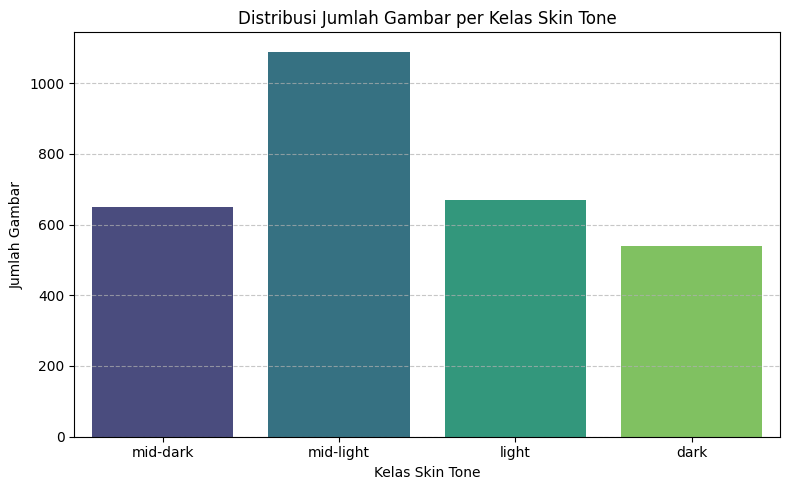

In [7]:
# Path dataset yang sudah dibersihkan
datasets = './datasets'

def count_images_per_class(dataset_path):
    """
    Mengembalikan dictionary jumlah gambar (.jpg/.png/.jpeg) per kelas dari dataset.
    """
    return {
        class_name: len([
            f for f in os.listdir(os.path.join(dataset_path, class_name))
            if os.path.isfile(os.path.join(dataset_path, class_name, f)) and
               f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        for class_name in os.listdir(dataset_path)
        if os.path.isdir(os.path.join(dataset_path, class_name))
    }

# Hitung jumlah gambar per kelas
class_counts = count_images_per_class(datasets)

# Cetak hasil
print("Distribusi jumlah gambar per kelas:", class_counts)

# Visualisasi distribusi kelas
plt.figure(figsize=(8, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')
plt.title('Distribusi Jumlah Gambar per Kelas Skin Tone')
plt.xlabel('Kelas Skin Tone')
plt.ylabel('Jumlah Gambar')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

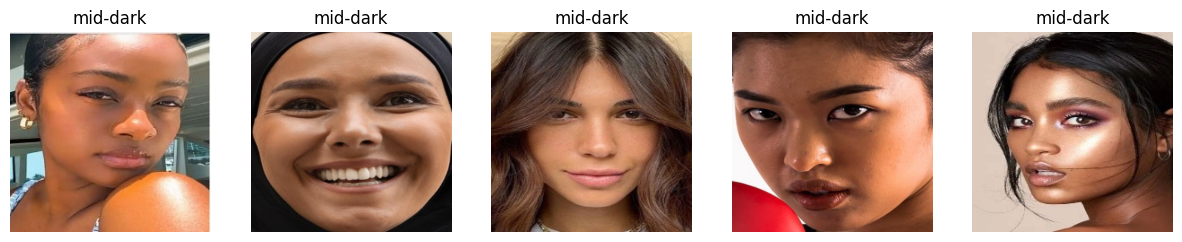

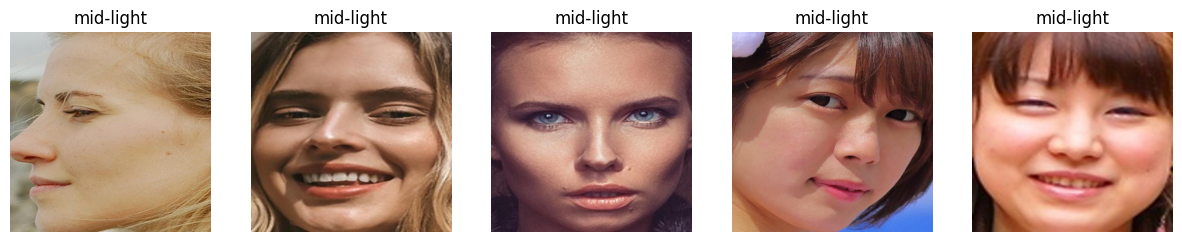

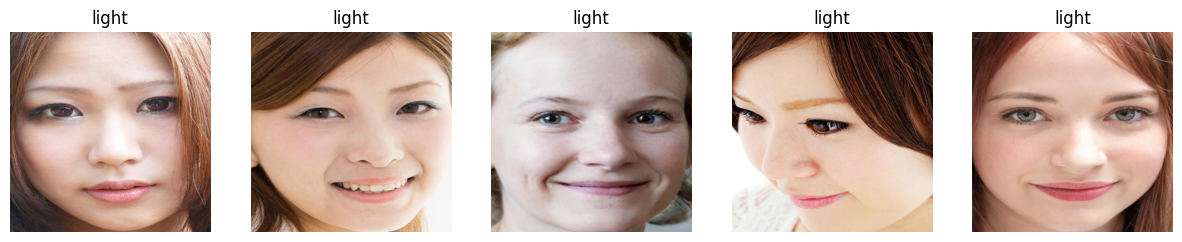

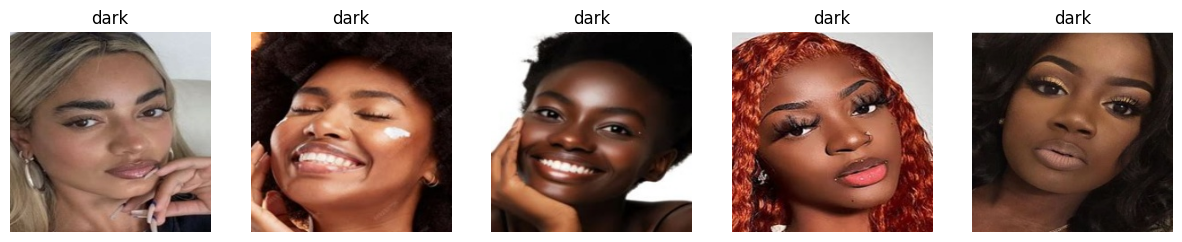

In [8]:
#Visualisasi gambar di setiap kelasnya
def show_samples(datasets, class_name, n=5):
    folder = os.path.join(datasets, class_name)
    images = os.listdir(folder)[:n]
    plt.figure(figsize=(15, 3))
    for i, img_file in enumerate(images):
        img_path = os.path.join(folder, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.show()

for skin_class in os.listdir(datasets):
    show_samples(datasets, skin_class)

In [9]:
def check_image_sizes(dataset_path):
    """
    Mengumpulkan ukuran (width, height) semua gambar dalam dataset dan menampilkan statistik deskriptif.
    """
    sizes = []
    for skin_class in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, skin_class)
        if not os.path.isdir(class_path):
            continue

        for file in os.listdir(class_path):
            img_path = os.path.join(class_path, file)
            try:
                with Image.open(img_path) as img:
                    sizes.append(img.size)
            except Exception as e:
                print(f"Error membuka gambar {img_path}: {e}")

    sizes_df = pd.DataFrame(sizes, columns=['Width', 'Height'])
    print(sizes_df.describe())
    return sizes_df

# Cek Ukuran Gambar
sizes_df = check_image_sizes(datasets)

             Width       Height
count  2946.000000  2946.000000
mean    420.301426   420.301426
std     134.188946   134.188946
min     224.000000   224.000000
25%     224.000000   224.000000
50%     512.000000   512.000000
75%     512.000000   512.000000
max     512.000000   512.000000


In [10]:
# Distribusi Warna Dominan
def get_dominant_color(img_path, k=3):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.reshape((-1, 3))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(img)
    return kmeans.cluster_centers_.astype(int)

# Contoh ambil warna dari 1 gambar di tiap kelas
for skin_class in os.listdir(datasets):
    sample_img = os.listdir(os.path.join(datasets, skin_class))[0]
    color = get_dominant_color(os.path.join(datasets, skin_class, sample_img))
    print(f"{skin_class} dominant color:", color)

mid-dark dominant color: [[ 96  76  63]
 [227 202 187]
 [193 119  82]]
mid-light dominant color: [[180 149 112]
 [136 100  63]
 [196 173 148]]
light dominant color: [[ 96  64  53]
 [230 204 195]
 [186 141 124]]
dark dominant color: [[199 191 187]
 [155 116  99]
 [ 81  64  54]]


Insight:
1. Ukuran gambar perlu di resize dan disamakan ke 224*224 agar cocok ke pretrained model
2. Dominan color dalam satu kelas masih terdapat perbedaan mencolok sepertinya dipengaruhi warna rambut dan background maka perlu di cropping agar fokus di bagian wajah.
3. distribusi data masih belum seimbang sehingga perlu dilakukan undersampling dan augmentasi untuk menyamakan kelas. Selain itu mungkin augmentasi diperlukan untuk setiap kelas untuk robustness model

# **Data Preparation**



## **Cropping Face**

In [19]:
def crop_faces(source_dir, output_dir):
    detector = MTCNN()  # Inisialisasi detektor wajah dari MTCNN
    total_cropped = 0  # Hitung jumlah gambar yang berhasil di-crop
    failed = []        # Simpan path gambar yang gagal diproses

    print(f"Cropping faces (by keypoints) from {source_dir}...")

    # Loop setiap folder (kelas) dalam source_dir
    for class_name in os.listdir(source_dir):
        class_input_path = os.path.join(source_dir, class_name)
        class_output_path = os.path.join(output_dir, class_name)

        # Lewati jika bukan folder
        if not os.path.isdir(class_input_path):
            continue

        # Buat folder output jika belum ada
        os.makedirs(class_output_path, exist_ok=True)

        # Ambil semua file gambar
        image_files = [
            f for f in os.listdir(class_input_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]

        # Loop setiap gambar
        for img_name in tqdm(image_files, desc=f"Processing {class_name}"):
            input_path = os.path.join(class_input_path, img_name)
            output_path = os.path.join(class_output_path, img_name)

            try:
                # Baca gambar
                img = cv2.imread(input_path)
                if img is None:
                    raise ValueError("Image cannot be read")  # Error jika gambar rusak atau tidak bisa dibaca

                # Konversi ke RGB karena MTCNN menggunakan format RGB
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Deteksi wajah
                faces = detector.detect_faces(img_rgb)
                if not faces:
                    raise ValueError("No faces detected")  # Error jika wajah tidak terdeteksi

                face = faces[0]  # Ambil wajah pertama yang terdeteksi
                keypoints = face['keypoints']

                # Ambil koordinat titik-titik kunci wajah
                leye = np.array(keypoints['left_eye'])
                reye = np.array(keypoints['right_eye'])
                nose = np.array(keypoints['nose'])
                mouth_left = np.array(keypoints['mouth_left'])
                mouth_right = np.array(keypoints['mouth_right'])

                # Hitung titik tengah wajah
                eye_center = (leye + reye) / 2
                mouth_center = (mouth_left + mouth_right) / 2
                center = (eye_center + mouth_center) / 2

                # Estimasi ukuran wajah berdasarkan jarak antara fitur
                face_height = int(np.linalg.norm(eye_center - mouth_center) * 2)
                face_width = int(np.linalg.norm(leye - reye) * 2.5)

                # Hitung koordinat crop dan clamp agar tidak keluar batas gambar
                x1 = max(0, int(center[0] - face_width // 2))
                y1 = max(0, int(center[1] - face_height // 2))
                x2 = min(img.shape[1], int(center[0] + face_width // 2))
                y2 = min(img.shape[0], int(center[1] + face_height // 2))

                # Lewati jika wajah terlalu kecil
                if (x2 - x1) < 60 or (y2 - y1) < 60:
                    raise ValueError("Crop size too small")

                # Crop wajah dan simpan
                face_crop = img[y1:y2, x1:x2]
                face_rgb = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)
                Image.fromarray(face_rgb).save(output_path)
                total_cropped += 1

            except Exception as e:
                # Simpan nama file yang gagal, dan salin gambar original ke output
                failed.append(input_path)
                shutil.copy2(input_path, output_path)

    # Ringkasan proses cropping
    print(f"\nCropping complete. Total cropped: {total_cropped}")
    if failed:
        print(f"Total failed (copied as-is): {len(failed)}")
        for f in failed:
            print(f"- {f}")

In [20]:
source_dir = "/content/datasets"
output_dir = "/content/datasets_cropped"

crop_faces(source_dir, output_dir)

Cropping faces (by keypoints) from /content/datasets...


Processing dark: 100%|██████████| 539/539 [01:48<00:00,  4.95it/s]


Cropping complete. Total cropped: 2921
Total failed (copied as-is): 25
- /content/datasets/mid-light/62018723.jpg
- /content/datasets/mid-light/95357578.jpg
- /content/datasets/mid-light/70906981.jpg
- /content/datasets/mid-light/68425609.jpg
- /content/datasets/mid-light/62712610.jpg
- /content/datasets/mid-light/95907815.jpg
- /content/datasets/mid-light/66035454.jpg
- /content/datasets/mid-light/76196627.jpg
- /content/datasets/mid-light/106389668.jpg
- /content/datasets/mid-light/image_4498.jpg
- /content/datasets/mid-light/57634623.jpg
- /content/datasets/mid-light/77508396.jpg
- /content/datasets/mid-light/108137621.jpg
- /content/datasets/mid-light/77488026.jpg
- /content/datasets/mid-light/58747586.jpg
- /content/datasets/mid-light/37556088.jpg
- /content/datasets/mid-light/90181153.jpg
- /content/datasets/mid-light/43272362.jpg
- /content/datasets/mid-light/27396280.jpg
- /content/datasets/light/7235975.jpg
- /content/datasets/light/1958315.jpg
- /content/datasets/light/94638

In [21]:
datasets_new = './datasets_cropped'

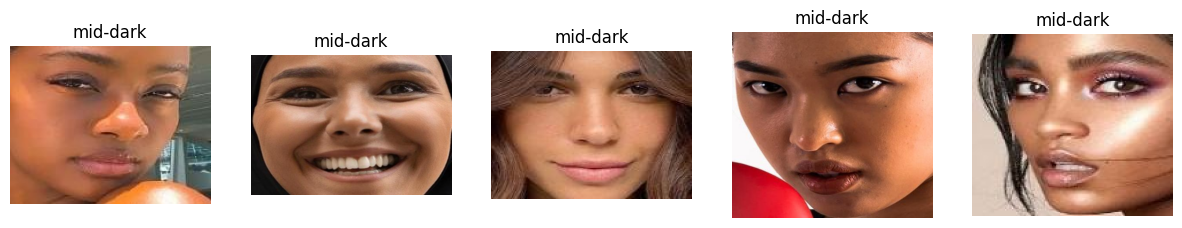

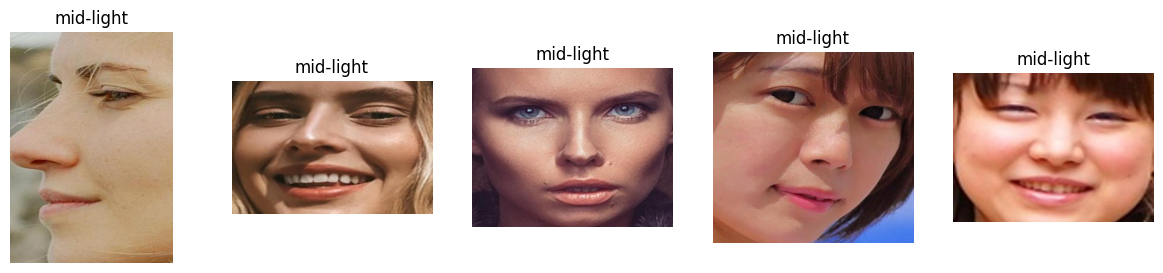

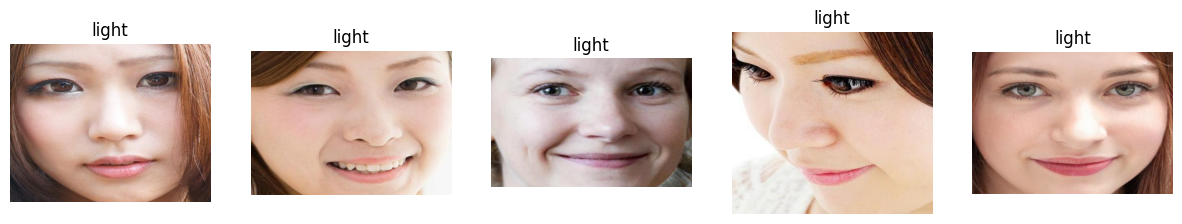

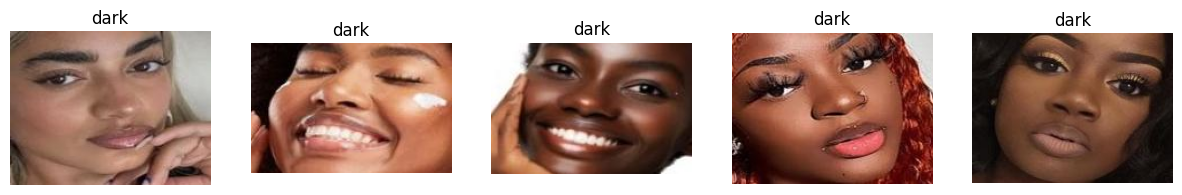

In [22]:
for skin_class in os.listdir(datasets_new):
    show_samples(datasets_new, skin_class)

In [27]:
class_counts = count_images_per_class(datasets_new)

# Cetak hasil
print("Distribusi jumlah gambar per kelas:", class_counts)

Distribusi jumlah gambar per kelas: {'mid-dark': 650, 'mid-light': 1089, 'light': 668, 'dark': 539}


## **Resize**

In [29]:
def resize_images(source_dir, output_dir, target_size=(224, 224)):
    """
    Resize semua gambar dari source_dir ke ukuran target dan simpan ke output_dir
    dengan struktur folder kelas yang sama.
    """
    print(f"\nResizing images from {source_dir} to {target_size} and saving to {output_dir}...")
    total_resized = 0
    errored_files = []

    # Buat direktori output utama jika belum ada
    os.makedirs(output_dir, exist_ok=True)

    for class_name in os.listdir(source_dir):
        class_source_path = os.path.join(source_dir, class_name)
        class_output_path = os.path.join(output_dir, class_name) # Path untuk kelas di folder output

        if not os.path.isdir(class_source_path):
            continue

        # Buat direktori kelas di dalam folder output jika belum ada
        os.makedirs(class_output_path, exist_ok=True)

        print(f"  Processing class: {class_name}")
        image_files = [
            f for f in os.listdir(class_source_path)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]

        for img_file in tqdm(image_files, desc=f"    Resizing {class_name}"):
            source_img_path = os.path.join(class_source_path, img_file)
            # output_img_path = os.path.join(class_output_path, img_file) # Path file output

            try:
                with Image.open(source_img_path) as img:
                    # Konversi ke RGB jika bukan
                    if img.mode != 'RGB':
                        img = img.convert('RGB')

                    # Resize dengan antialiasing
                    try:
                        img_resized = img.resize(target_size, Image.Resampling.LANCZOS)
                    except AttributeError:
                        img_resized = img.resize(target_size, Image.LANCZOS)

                    # Simpan ke folder output baru
                    output_img_path_jpg = os.path.splitext(os.path.join(class_output_path, img_file))[0] + ".jpg"
                    img_resized.save(output_img_path_jpg, format='JPEG', quality=95)

                    total_resized += 1

            except Exception as e:
                print(f"    Error resizing {source_img_path}: {e}")
                errored_files.append(source_img_path)

    print("\nImage resizing complete.")
    print(f"Total images resized: {total_resized}")
    if errored_files:
        print(f"Files with errors during resizing ({len(errored_files)}):")
        for f in errored_files:
            print(f"  - {f}")

In [30]:
resized_dataset = "./dataset-skin-tone_resized"

# Jalankan fungsi resize
resize_images(datasets_new, resized_dataset, target_size=(224, 224))


Resizing images from ./datasets_cropped to (224, 224) and saving to ./dataset-skin-tone_resized...
  Processing class: mid-dark


    Resizing mid-dark: 100%|██████████| 650/650 [00:01<00:00, 374.62it/s]


  Processing class: mid-light


    Resizing mid-light: 100%|██████████| 1089/1089 [00:06<00:00, 169.42it/s]


  Processing class: light


    Resizing light: 100%|██████████| 668/668 [00:03<00:00, 210.03it/s]


  Processing class: dark


    Resizing dark: 100%|██████████| 539/539 [00:01<00:00, 438.26it/s]


Image resizing complete.
Total images resized: 2946


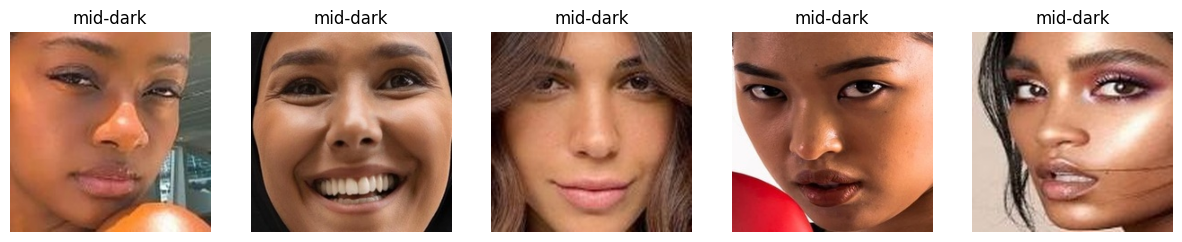

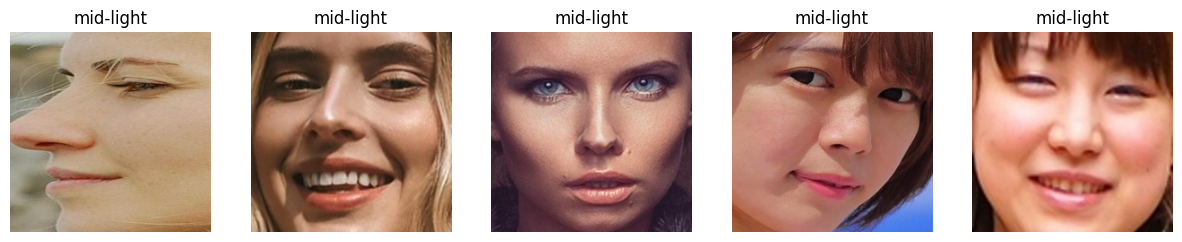

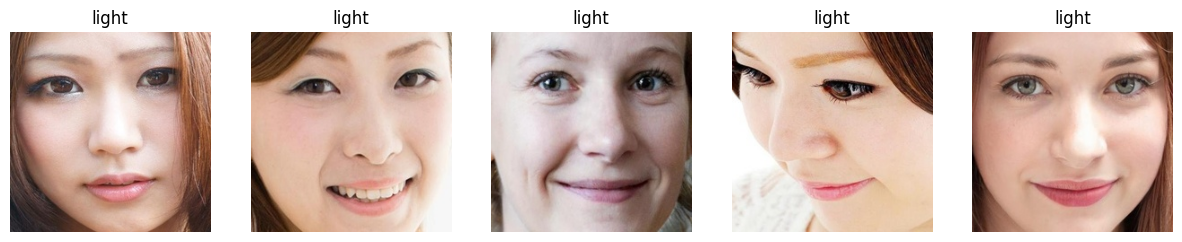

In [31]:
for skin_class in os.listdir(resized_dataset):
    show_samples(resized_dataset, skin_class)

In [32]:
# Cek Ukuran Gambar
sizes_df = check_image_sizes(resized_dataset)

        Width  Height
count  2946.0  2946.0
mean    224.0   224.0
std       0.0     0.0
min     224.0   224.0
25%     224.0   224.0
50%     224.0   224.0
75%     224.0   224.0
max     224.0   224.0


In [33]:
# Contoh ambil warna dari 1 gambar di tiap kelas
for skin_class in os.listdir(resized_dataset):
    sample_img = os.listdir(os.path.join(resized_dataset, skin_class))[0]
    color = get_dominant_color(os.path.join(resized_dataset, skin_class, sample_img))
    print(f"{skin_class} dominant color:", color)

mid-dark dominant color: [[100  80  67]
 [216 149 113]
 [174 104  72]]
mid-light dominant color: [[194 168 142]
 [128  98  70]
 [174 146 114]]
light dominant color: [[186 140 123]
 [228 201 192]
 [ 94  63  52]]
dark dominant color: [[192 167 156]
 [160 118 101]
 [101  72  60]]


In [35]:
!zip -r resized-datasets-hijabist.zip /content/dataset-skin-tone_resized
from google.colab import files
files.download('resized-datasets-hijabist.zip')

  adding: content/dataset-skin-tone_resized/ (stored 0%)
  adding: content/dataset-skin-tone_resized/mid-dark/ (stored 0%)
  adding: content/dataset-skin-tone_resized/mid-dark/287_19ea605d.jpg (deflated 1%)
  adding: content/dataset-skin-tone_resized/mid-dark/82318621.jpg (deflated 1%)
  adding: content/dataset-skin-tone_resized/mid-dark/546_2ff55abd.jpg (deflated 1%)
  adding: content/dataset-skin-tone_resized/mid-dark/55205181.jpg (deflated 1%)
  adding: content/dataset-skin-tone_resized/mid-dark/991_f6b4bf42.jpg (deflated 1%)
  adding: content/dataset-skin-tone_resized/mid-dark/1071_5470115f.jpg (deflated 1%)
  adding: content/dataset-skin-tone_resized/mid-dark/233_a50e2571.jpg (deflated 1%)
  adding: content/dataset-skin-tone_resized/mid-dark/1068_c36949c6.jpg (deflated 1%)
  adding: content/dataset-skin-tone_resized/mid-dark/1418_1a25d506.jpg (deflated 1%)
  adding: content/dataset-skin-tone_resized/mid-dark/image_5866.jpg (deflated 1%)
  adding: content/dataset-skin-tone_resized/

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Undersampling**

In [36]:
def reduce_class_samples(source_dir, dest_dir, class_limits):
    """
    Menyalin maksimal N gambar dari tiap kelas ke folder baru secara acak,
    dan menghapus isi folder sebelumnya jika sudah ada.
    """
    print(f"\nMengurangi jumlah data dan menyalin ke folder baru: {dest_dir}")

    # Hapus folder tujuan jika sudah ada
    if os.path.exists(dest_dir):
        print("Folder sudah ada, menghapus isi sebelumnya...")
        shutil.rmtree(dest_dir)
    os.makedirs(dest_dir)

    # Untuk reprodusibilitas
    random.seed(42)

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        dest_class_path = os.path.join(dest_dir, class_name)
        os.makedirs(dest_class_path, exist_ok=True)

        all_images = [
            f for f in os.listdir(class_path)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]

        limit = class_limits.get(class_name, len(all_images))
        selected_images = random.sample(all_images, min(limit, len(all_images)))

        for img_name in selected_images:
            src_path = os.path.join(class_path, img_name)
            dst_path = os.path.join(dest_class_path, img_name)
            shutil.copy2(src_path, dst_path)

        print(f"  - {class_name}: {len(selected_images)} gambar disalin (maks {limit})")

In [37]:
# Path tujuan (dataset hasil pengurangan)
reduced_dataset = './dataset-skin-tone_reduced'

# Batas jumlah gambar per kelas
class_limits = {
    'light': 668,
    'mid-light': 680,
    'dark': 539,
    'mid-dark': 650
}

# Jalankan reduksi
reduce_class_samples(resized_dataset, reduced_dataset, class_limits)


Mengurangi jumlah data dan menyalin ke folder baru: ./dataset-skin-tone_reduced
  - mid-dark: 650 gambar disalin (maks 650)
  - mid-light: 680 gambar disalin (maks 680)
  - light: 668 gambar disalin (maks 668)
  - dark: 539 gambar disalin (maks 539)


# **Data Splitting**

In [ ]:
shutil.rmtree("/content/dataset-skin-tone_split")

In [38]:
def split_dataset(source_dir, dest_dir, train_ratio=0.8):
    """
    Memisahkan dataset ke dalam folder 'train' dan 'val' dengan rasio tertentu.
    """
    print(
        f"\nMembagi dataset dari {source_dir} ke dalam train/val "
        f"dengan rasio {int(train_ratio * 100)}/{int((1 - train_ratio) * 100)}..."
    )

    # Buat folder tujuan untuk setiap split dan kelas
    classes = [
        d for d in os.listdir(source_dir)
        if os.path.isdir(os.path.join(source_dir, d))
    ]
    for split in ('train', 'val'):
        for cls in classes:
            os.makedirs(os.path.join(dest_dir, split, cls), exist_ok=True)

    # Proses per kelas secara stratified
    for cls in classes:
        class_path = os.path.join(source_dir, cls)
        all_images = [
            f for f in os.listdir(class_path)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
        random.shuffle(all_images)

        split_index = int(len(all_images) * train_ratio)
        train_images = all_images[:split_index]
        val_images = all_images[split_index:]

        # Salin file sesuai pembagian
        for split_name, images in [('train', train_images), ('val', val_images)]:
            for img_name in images:
                src = os.path.join(class_path, img_name)
                dst = os.path.join(dest_dir, split_name, cls, img_name)
                shutil.copy2(src, dst)

    print("\nPembagian dataset selesai.")

def count_images_in_folder(base_dir, split):
    """
    Menghitung jumlah gambar dalam folder 'train' dan 'val'.
    """
    path = os.path.join(base_dir, split)
    if not os.path.exists(path):
        print(f"Folder '{path}' tidak ditemukan.")
        return

    print(f"\nJumlah data di folder {split}:")
    for cls in os.listdir(path):
        cls_path = os.path.join(path, cls)
        if os.path.isdir(cls_path):
            count = len([
                f for f in os.listdir(cls_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])
            print(f"  - {cls}: {count} gambar")

In [39]:
reduced_datasets = './dataset-skin-tone_reduced'
split_dataset_path = './dataset-skin-tone_split'

split_dataset(reduced_datasets, split_dataset_path, train_ratio=0.8)

count_images_in_folder(split_dataset_path, 'train')
count_images_in_folder(split_dataset_path, 'val')


Membagi dataset dari ./dataset-skin-tone_reduced ke dalam train/val dengan rasio 80/19...

Pembagian dataset selesai.

Jumlah data di folder train:
  - mid-dark: 520 gambar
  - mid-light: 544 gambar
  - light: 534 gambar
  - dark: 431 gambar

Jumlah data di folder val:
  - mid-dark: 130 gambar
  - mid-light: 136 gambar
  - light: 134 gambar
  - dark: 108 gambar


In [43]:
!zip -r splitted-datasets-hijabist.zip /content/dataset-skin-tone_split
from google.colab import files
files.download('splitted-datasets-hijabist.zip')

  adding: content/dataset-skin-tone_split/ (stored 0%)
  adding: content/dataset-skin-tone_split/train/ (stored 0%)
  adding: content/dataset-skin-tone_split/train/mid-dark/ (stored 0%)
  adding: content/dataset-skin-tone_split/train/mid-dark/287_19ea605d.jpg (deflated 1%)
  adding: content/dataset-skin-tone_split/train/mid-dark/82318621.jpg (deflated 1%)
  adding: content/dataset-skin-tone_split/train/mid-dark/546_2ff55abd.jpg (deflated 1%)
  adding: content/dataset-skin-tone_split/train/mid-dark/991_f6b4bf42.jpg (deflated 1%)
  adding: content/dataset-skin-tone_split/train/mid-dark/1071_5470115f.jpg (deflated 1%)
  adding: content/dataset-skin-tone_split/train/mid-dark/1068_c36949c6.jpg (deflated 1%)
  adding: content/dataset-skin-tone_split/train/mid-dark/1418_1a25d506.jpg (deflated 1%)
  adding: content/dataset-skin-tone_split/train/mid-dark/374_95bcf7b3.jpg (deflated 1%)
  adding: content/dataset-skin-tone_split/train/mid-dark/1438_aa08356b.jpg (deflated 1%)
  adding: content/data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Augmentasi Data Training**

In [40]:
from uuid import uuid4

In [44]:
def augment_images(train_dir, target_count):
    """
    Melakukan augmentasi gambar di folder train_dir agar setiap kelas memiliki
    jumlah gambar setidaknya sebanyak target_count.
    """

    # Konfigurasi ImageDataGenerator untuk augmentasi gambar.
    augmentor = ImageDataGenerator(
        rotation_range=20,        # Rotasi acak hingga 20 derajat.
        zoom_range=0.1,           # Zoom acak hingga 10%.
        horizontal_flip=True,     # Flip horizontal secara acak.
        fill_mode='nearest',      # Mode pengisian untuk area kosong pasca augmentasi.
    )

    # Loop untuk setiap folder kelas di direktori pelatihan
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        if not os.path.isdir(class_path):
            continue  # Lewati jika bukan direktori (misalnya file README)

        # Ambil daftar gambar asli (tanpa 'aug' di nama file) di kelas ini
        images = [
            f for f in os.listdir(class_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png')) and 'aug' not in f.lower()
        ]
        current_count = len(images)  # Jumlah gambar asli saat ini

        # Jika jumlah gambar sudah mencukupi, lewati augmentasi untuk kelas ini
        if current_count >= target_count:
            print(f"Kelas '{class_name}' sudah cukup: {current_count}/{target_count}")
            continue

        needed = target_count - current_count  # Jumlah gambar yang perlu ditambahkan
        per_image_aug_count = (needed // len(images)) + 1  # Jumlah augmentasi per gambar
        augmented_count = 0  # Counter jumlah augmentasi yang telah dibuat

        print(f"\nAugmentasi kelas {class_name} ({needed} gambar dibutuhkan):")

        # Loop setiap gambar asli dan lakukan augmentasi
        for img_name in images:
            if augmented_count >= needed:
                break  # Stop jika augmentasi sudah cukup

            img_path = os.path.join(class_path, img_name)
            try:
                # Buka gambar dan ubah ke array
                img = Image.open(img_path).convert('RGB')
                img_array = np.expand_dims(np.array(img), axis=0)

                i = 0  # Counter untuk jumlah augmentasi dari gambar ini

                # Lakukan augmentasi menggunakan flow generator
                for batch in augmentor.flow(
                    img_array,
                    batch_size=1,
                    save_to_dir=None,      # Kita simpan secara manual
                    save_format='jpg'
                ):
                    # Buat nama file unik menggunakan UUID pendek
                    unique_id = uuid4().hex[:8]
                    new_filename = f"aug_{class_name}_{unique_id}.jpg"
                    save_path = os.path.join(class_path, new_filename)

                    # Simpan hasil augmentasi
                    Image.fromarray(batch[0].astype(np.uint8)).save(save_path, format='JPEG', quality=95)

                    i += 1
                    augmented_count += 1

                    # Hentikan augmentasi dari gambar ini jika sudah cukup
                    if i >= per_image_aug_count or augmented_count >= needed:
                        break

                    # Log setiap 50 gambar baru
                    if augmented_count % 50 == 0:
                        print(f"Generated: {augmented_count}/{needed}")

            except Exception as e:
                # Tangani error pada gambar yang rusak atau tidak bisa dibuka
                print(f"Error pada {img_path}: {str(e)[:50]}")

    # Cek akhir jumlah gambar per kelas setelah augmentasi
    final_count = {
        class_name: len([
            f for f in os.listdir(os.path.join(train_dir, class_name))
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        for class_name in os.listdir(train_dir)
    }

    print("\nHasil akhir distribusi gambar:")
    for k, v in final_count.items():
        print(f"{k}: {v} gambar")

In [45]:
train_dir = './dataset-skin-tone_split/train'
augment_images(train_dir, target_count=700)


Augmentasi kelas mid-dark (180 gambar dibutuhkan):

Augmentasi kelas mid-light (156 gambar dibutuhkan):

Augmentasi kelas light (166 gambar dibutuhkan):

Augmentasi kelas dark (269 gambar dibutuhkan):

Hasil akhir distribusi gambar:
mid-dark: 700 gambar
mid-light: 700 gambar
light: 700 gambar
dark: 700 gambar


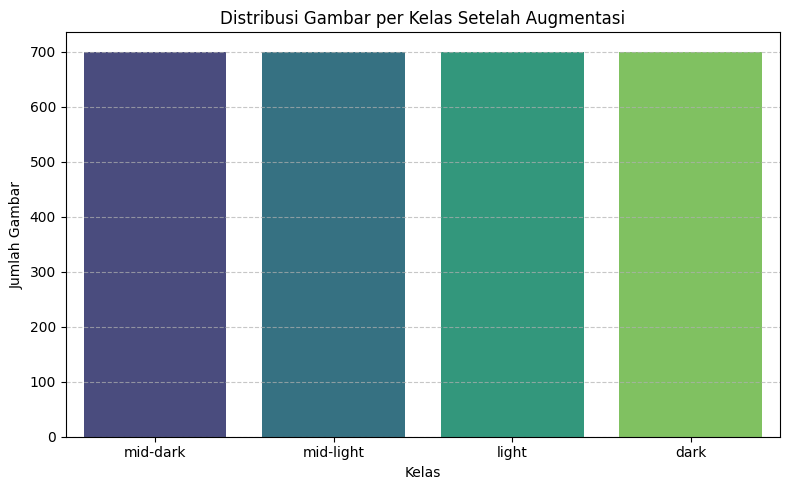

In [46]:
def plot_class_distribution(train_dir):
    """Hitung dan visualisasikan distribusi jumlah gambar per kelas"""
    final_count = {}
    classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

    for class_name in classes:
        class_path = os.path.join(train_dir, class_name)
        count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        final_count[class_name] = count

    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(final_count.keys()), y=list(final_count.values()), palette='viridis')
    plt.title('Distribusi Gambar per Kelas Setelah Augmentasi')
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Gambar')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Visualisasi distribusi data
plot_class_distribution(train_dir)

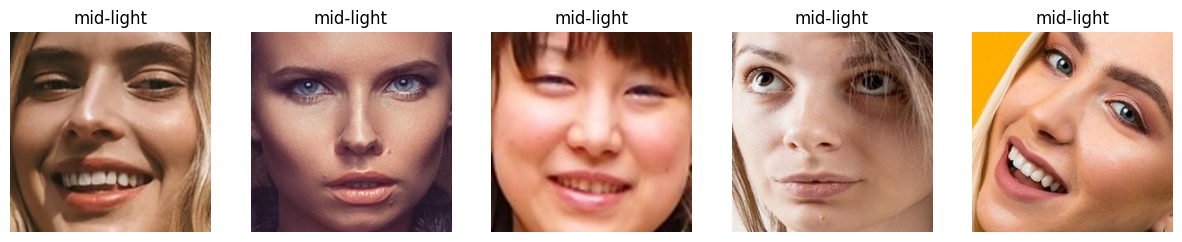

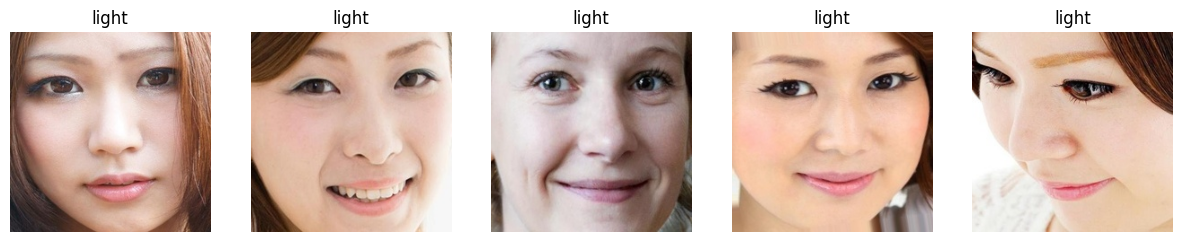

In [47]:
for skin_class in os.listdir(train_dir):
    show_samples(train_dir, skin_class)

# **Data Generator Setup**

In [50]:
# Direktori dataset
train_dir = "./dataset-skin-tone_split/train"
val_dir = "./dataset-skin-tone_split/val"

# Normalisasi pixel gambar ke [0, 1]
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Data generator untuk training
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)

# Data generator untuk validasi
val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 2800 images belonging to 4 classes.
Found 508 images belonging to 4 classes.


In [ ]:
print(f"jumlah kelas :", len(train_generator.class_indices))
print(train_generator.class_indices)  # Mengecek jumlah kelas yang dikenali

jumlah kelas : 4
{'dark': 0, 'light': 1, 'mid-dark': 2, 'mid-light': 3}


In [49]:
files.download('hijabist-skintone-final.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Modelling**

In [51]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Base model MobileNet tanpa top, tapi pretrained di ImageNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Set semua layer agar bisa di-fine-tune
for layer in base_model.layers:
    layer.trainable = True

# Tambahkan custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [52]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [53]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('model_best.keras', save_best_only=True, monitor='val_loss', verbose=1),
    ModelCheckpoint('model_best.h5', save_best_only=True, monitor='val_loss', verbose=1)
]

In [54]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.5581 - loss: 1.0881
Epoch 1: val_loss improved from inf to 0.99046, saving model to model_best.keras

Epoch 1: val_loss improved from inf to 0.99046, saving model to model_best.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 57s 301ms/step - accuracy: 0.5595 - loss: 1.0848 - val_accuracy: 0.6142 - val_loss: 0.9905 - learning_rate: 1.0000e-04
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8357 - loss: 0.4267
Epoch 2: val_loss improved from 0.99046 to 0.59232, saving model to model_best.keras

Epoch 2: val_loss improved from 0.99046 to 0.59232, saving model to model_best.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.8358 - loss: 0.4265 - val_accuracy: 0.7461 - val_loss: 0.5923 - learning_rate: 1.0000e-04
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8969 - loss: 0.2634
Epoch 3: val_loss improved from 0.59232 to 0.32213, saving model to model_best.keras

Epoch 3: val_loss improved from 0.59232 to 0.32213, saving model to model_best.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.8969 - loss: 0.2635 - val_accuracy: 0.8780 - val_loss: 0.3221 - learning_rate: 1.0000e-04
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9302 - loss: 0.1885
Epoch 4: val_loss did not improve from 0.32213

Epoch 4: val_loss did not improve from 0.32213
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.9303 - loss: 0.1883 - val_accuracy: 0.8780 - val_loss: 0.3353 - learning_rate: 1.0000e-04
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9663 - loss: 0.0993
Epoch 5: val_loss did not improve from 0.32213

Epoch 5: val_loss did not improve from 0.32213
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.9663 - loss: 0.0994 - val_accuracy: 0.8720 - val_loss: 0.4023 - learning_rate: 1.0000e-04
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9706 - loss: 0.0961
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 6: val_loss did not improve from 0

88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.9805 - loss: 0.0621 - val_accuracy: 0.8819 - val_loss: 0.2981 - learning_rate: 2.0000e-05
Epoch 8/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9786 - loss: 0.0593
Epoch 8: val_loss improved from 0.29808 to 0.26594, saving model to model_best.keras

Epoch 8: val_loss improved from 0.29808 to 0.26594, saving model to model_best.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.9787 - loss: 0.0592 - val_accuracy: 0.8996 - val_loss: 0.2659 - learning_rate: 2.0000e-05
Epoch 9/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9867 - loss: 0.0430
Epoch 9: val_loss improved from 0.26594 to 0.25988, saving model to model_best.keras

Epoch 9: val_loss improved from 0.26594 to 0.25988, saving model to model_best.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.9867 - loss: 0.0431 - val_accuracy: 0.9094 - val_loss: 0.2599 - learning_rate: 2.0000e-05
Epoch 10/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9796 - loss: 0.0624
Epoch 10: val_loss did not improve from 0.25988

Epoch 10: val_loss did not improve from 0.25988
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 102ms/step - accuracy: 0.9796 - loss: 0.0625 - val_accuracy: 0.8996 - val_loss: 0.2754 - learning_rate: 2.0000e-05
Epoch 11/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9789 - loss: 0.0556
Epoch 11: val_loss did not improve from 0.25988

Epoch 11: val_loss did not improve from 0.25988
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.9790 - loss: 0.0555 - val_accuracy: 0.9114 - val_loss: 0.2749 - learning_rate: 2.0000e-05
Epoch 12/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9908 - loss: 0.0354
Epoch 12: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.

Epoch 12: val_loss did not improv

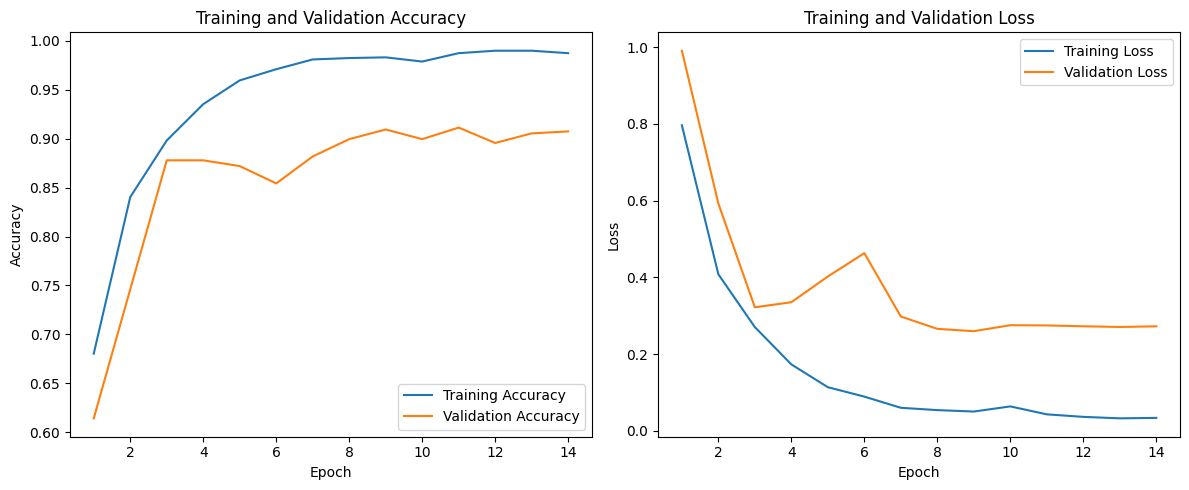

In [55]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Panggil fungsi ini setelah training
plot_training_history(history)

In [56]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import seaborn as sns

# Prediksi di data validasi
val_generator.reset()
pred_probs = model.predict(val_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# metrik evaluasi
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"\n Evaluasi Model:")
print(f" - Accuracy : {acc:.4f}")
print(f" - Precision: {prec:.4f}")
print(f" - Recall   : {rec:.4f}")
print(f" - F1-Score : {f1:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 279ms/step

 Evaluasi Model:
 - Accuracy : 0.9094
 - Precision: 0.9105
 - Recall   : 0.9101
 - F1-Score : 0.9096



 Classification Report:
              precision    recall  f1-score   support

        dark       0.90      0.94      0.92       108
       light       0.95      0.93      0.94       134
    mid-dark       0.92      0.85      0.88       130
   mid-light       0.87      0.93      0.90       136

    accuracy                           0.91       508
   macro avg       0.91      0.91      0.91       508
weighted avg       0.91      0.91      0.91       508



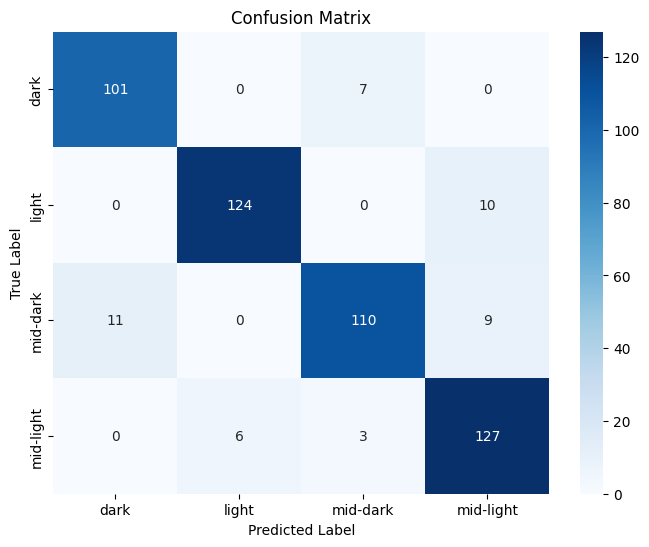

In [57]:
# Classification report
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [72]:
files.download('/content/model_best.keras')
files.download('/content/model_best.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Konversi Model**

In [60]:
import tensorflow as tf

## **Konversi ke Saved_model**

In [61]:
# Load model
model = tf.keras.models.load_model('/content/model_best.keras')

# Konversi ke Saved_Model
model.export('/content/saved_model/1')

Saved artifact at '/content/saved_model/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  137789756959120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137789756956816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137789756955664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137789756948944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137789756959696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137789756958160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137789756961232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137789756962192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137789756962000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137789756958352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137789756

In [64]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 6,699,274 (25.56 MB)

 Trainable params: 3,338,692 (12.74 MB)

 Non-trainable params: 21,888 (85.50 KB)

 Optimizer params: 3,338,694 (12.74 MB)

In [62]:
!zip -r saved_model_ricky1.zip /content/saved_model
from google.colab import files
files.download('saved_model_ricky1.zip')

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/1/ (stored 0%)
  adding: content/saved_model/1/fingerprint.pb (stored 0%)
  adding: content/saved_model/1/assets/ (stored 0%)
  adding: content/saved_model/1/variables/ (stored 0%)
  adding: content/saved_model/1/variables/variables.index (deflated 78%)
  adding: content/saved_model/1/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/saved_model/1/saved_model.pb (deflated 90%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Konversi ke Tfjs**

In [66]:
!pip install packaging==23.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-core 0.3.59 requires packaging<25,>=23.2, but you have packaging 23.1 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.1 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.1 which is incompatible.
langsmith 0.3.42 requires packaging>=23.2, but you have packaging 23.1 which is incompatible.
xarray 2025.3.1 requires packaging>=23.2, but you have packaging 23.1 which is incompatible.


In [67]:
!pip install tensorflow==2.18.0 tensorflowjs -q

In [68]:
# Konversi Saved_Model ke TensorFlow.js
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    /content/saved_model/1 \
    /content/modeltfjs

print("Model berhasil dikonversi ke TensorFlow.js.")

2025-05-23 08:06:52.128526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747987612.151930   19707 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747987612.158828   19707 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-23 08:06:58.315042: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1747987618.315261   19707 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [69]:
!zip -r model_tfjs_ricky1.zip /content/modeltfjs
from google.colab import files
files.download('model_tfjs_ricky1.zip')

  adding: content/modeltfjs/ (stored 0%)
  adding: content/modeltfjs/group1-shard2of4.bin (deflated 7%)
  adding: content/modeltfjs/model.json (deflated 95%)
  adding: content/modeltfjs/group1-shard4of4.bin (deflated 8%)
  adding: content/modeltfjs/group1-shard1of4.bin (deflated 7%)
  adding: content/modeltfjs/group1-shard3of4.bin (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Konversi ke Tflite**

In [70]:
# Konversi Saved_Model ke format TFLite
save_path = '/content/saved_model/1'
converter = tf.lite.TFLiteConverter.from_saved_model(save_path)
tflite_model = converter.convert()
with tf.io.gfile.GFile('/content/model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model berhasil dikonversi ke TFLite dan disimpan sebagai model.tflite")

Model berhasil dikonversi ke TFLite dan disimpan sebagai model.tflite


In [71]:
labels = list(train_generator.class_indices.keys())
with open('labels.txt', 'w') as f:
  for label in labels:
    f.write(label + '\n')

# **Inference**

**Inferensi Model Klasifikasi Skin Tone dengan Data Baru**
#
 Deskripsi Kode:
Kode ini bertujuan untuk melakukan inferensi (prediksi) kelas skin tone dari gambar baru
menggunakan model yang sudah dilatih sebelumnya.
Alur kerja utama adalah sebagai berikut:
1. Impor library yang dibutuhkan.
2. Inisialisasi detektor wajah MTCNN.
3. Muat model klasifikasi skin tone yang sudah dilatih (.keras atau .h5).
4. Definisikan label kelas dan ukuran target gambar.
5. Definisikan fungsi preprocessing gambar:
   - Membaca gambar.
   - Mendeteksi wajah menggunakan MTCNN.
   - Melakukan cropping pada wajah yang terdeteksi berdasarkan keypoints (mata, hidung, mulut).
   - Me-resize hasil crop wajah ke ukuran target.
   - Mengonversi warna gambar ke RGB.
   - Normalisasi nilai piksel gambar ke rentang [0, 1].
   - Menambahkan dimensi batch agar sesuai dengan input model.
6. Definisikan fungsi prediksi:
   - Menerima path gambar, model, dan label kelas.
   - Memanggil fungsi preprocessing.
   - Melakukan prediksi menggunakan model.
   - Menampilkan kelas prediksi, tingkat keyakinan, dan gambar yang diproses.
7. Definisikan fungsi untuk menerima input gambar dari pengguna (menggunakan fitur upload Google Colab).
8. Menjalankan fungsi unggah dan prediksi.

In [73]:
import tensorflow as tf
import numpy as np
import cv2  # OpenCV untuk pemrosesan gambar
from PIL import Image # Pillow untuk beberapa operasi gambar jika diperlukan (di sini plt juga memakai)
import matplotlib.pyplot as plt # Untuk menampilkan gambar
from google.colab import files # Untuk fitur upload file di Google Colab
from mtcnn.mtcnn import MTCNN # Untuk deteksi wajah
import os # Untuk operasi terkait sistem file (misalnya, menghapus file)

In [74]:
# Inisialisasi detektor wajah MTCNN
# MTCNN akan digunakan untuk mendeteksi lokasi wajah dan keypoints pada gambar.
try:
    detector = MTCNN()
    print("Detektor MTCNN berhasil diinisialisasi.")
except Exception as e:
    print(f"Gagal menginisialisasi MTCNN: {e}")
    detector = None # Set detector menjadi None jika gagal

# Muat model terbaik yang sudah dilatih
# Ganti path berikut sesuai dengan lokasi dan nama file model Anda.
# Kode ini mencoba memuat format .keras terlebih dahulu, kemudian .h5 jika gagal.
model_path_keras = '/content/model_best.keras'  # Path untuk model format Keras v3
model_path_h5 = '/content/model_best.h5'      # Path untuk model format HDF5 (legacy)
model = None

if detector: # Hanya lanjut jika MTCNN berhasil diinisialisasi
    try:
        model = tf.keras.models.load_model(model_path_keras)
        print(f"Model berhasil dimuat dari {model_path_keras}")
    except Exception as e_keras:
        print(f"Gagal memuat model dari {model_path_keras}: {e_keras}")
        print(f"Mencoba memuat dari format .h5...")
        try:
            model = tf.keras.models.load_model(model_path_h5)
            print(f"Model berhasil dimuat dari {model_path_h5}")
        except Exception as e_h5:
            print(f"Gagal memuat model dari {model_path_h5}: {e_h5}")
            print("Pastikan path model sudah benar dan file model tidak korup.")
else:
    print("MTCNN tidak terinisialisasi, proses inferensi tidak dapat dilanjutkan tanpa deteksi wajah.")

Detektor MTCNN berhasil diinisialisasi.
Model berhasil dimuat dari /content/model_best.keras


In [75]:
class_labels = ['dark', 'light', 'mid-dark', 'mid-light']
target_size = (224, 224)

In [76]:
def preprocess_image(image_path, detector_mtcnn, target_size_tuple=(224, 224)):
    """
    Melakukan preprocessing lengkap pada satu gambar untuk inferensi.
    Pipeline: Baca -> Deteksi Wajah (MTCNN) -> Crop Wajah (berbasis keypoints) -> Resize -> Normalisasi.

    Args:
        image_path (str): Path ke file gambar.
        detector_mtcnn (MTCNN): Objek detektor MTCNN yang sudah diinisialisasi.
        target_size_tuple (tuple): Ukuran target (height, width) untuk resize.

    Returns:
        numpy.ndarray: Gambar yang sudah diproses dan siap untuk model (dengan batch dimension),
                       atau None jika terjadi error.
    """
    if detector_mtcnn is None:
        print("Error: Detektor MTCNN tidak tersedia.")
        return None
    try:
        # 1. Baca gambar menggunakan OpenCV
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Gambar tidak dapat dibaca dari {image_path}. Pastikan path benar dan file tidak korup.")
            return None

        # 2. Konversi gambar dari BGR (OpenCV default) ke RGB (untuk MTCNN dan Matplotlib)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 3. Deteksi wajah menggunakan MTCNN
        faces = detector_mtcnn.detect_faces(img_rgb)

        if not faces:
            print(f"Peringatan: Tidak ada wajah terdeteksi pada gambar {os.path.basename(image_path)}.")
            return None # Kembalikan None jika tidak ada wajah

        # 4. Ambil wajah pertama yang terdeteksi (asumsi satu wajah utama per gambar)
        # Jika ada beberapa wajah, pertimbangkan logika untuk memilih wajah terbesar atau paling tengah.
        face_data = faces[0]
        keypoints = face_data['keypoints']

        # 5. Logika Cropping Wajah Berdasarkan Keypoints MTCNN
        # (Menggunakan logika yang sama seperti skrip cropping data training Anda)
        leye = np.array(keypoints['left_eye'])
        reye = np.array(keypoints['right_eye'])
        nose = np.array(keypoints['nose']) # Tidak digunakan di crop ini, tapi ada di keypoints
        mouth_left = np.array(keypoints['mouth_left'])
        mouth_right = np.array(keypoints['mouth_right'])

        eye_center = (leye + reye) / 2
        mouth_center = (mouth_left + mouth_right) / 2
        face_center = (eye_center + mouth_center) / 2

        # Estimasi tinggi dan lebar wajah dengan pengali heuristik
        # Sesuaikan pengali (2.0 dan 2.5) jika hasil crop kurang pas (terlalu sempit/lebar)
        face_height_est = int(np.linalg.norm(eye_center - mouth_center) * 2.0) # Tinggi: jarak mata-mulut x 2
        face_width_est = int(np.linalg.norm(leye - reye) * 2.5)            # Lebar: jarak antar mata x 2.5

        # Tentukan koordinat box untuk cropping
        x1 = max(0, int(face_center[0] - face_width_est // 2))
        y1 = max(0, int(face_center[1] - face_height_est // 2))
        x2 = min(img.shape[1], int(face_center[0] + face_width_est // 2))
        y2 = min(img.shape[0], int(face_center[1] + face_height_est // 2))

        # Periksa jika ukuran crop valid (tidak terlalu kecil)
        if (x2 - x1) < 30 or (y2 - y1) < 30: # Batas ukuran minimal bisa disesuaikan
            print(f"Peringatan: Wajah terdeteksi terlalu kecil untuk di-crop pada {os.path.basename(image_path)}.")
            return None

        # Lakukan cropping pada gambar BGR asli (img)
        face_crop_bgr = img[y1:y2, x1:x2]

        if face_crop_bgr.size == 0:
            print(f"Error: Hasil crop kosong untuk gambar {os.path.basename(image_path)}. Periksa koordinat crop.")
            return None

        # 6. Resize wajah yang sudah di-crop ke ukuran target
        # Gunakan interpolasi yang sama/mirip dengan saat training jika memungkinkan
        # cv2.INTER_AREA sering baik untuk memperkecil, cv2.INTER_CUBIC/LANCZOS4 untuk memperbesar/kualitas tinggi
        face_resized_bgr = cv2.resize(face_crop_bgr, target_size_tuple, interpolation=cv2.INTER_AREA)

        # 7. Konversi hasil resize ke RGB (jika model dilatih dengan input RGB)
        face_resized_rgb = cv2.cvtColor(face_resized_bgr, cv2.COLOR_BGR2RGB)

        # 8. Normalisasi nilai piksel ke rentang [0, 1] (sesuaikan jika training menggunakan normalisasi berbeda)
        face_normalized = face_resized_rgb.astype('float32') / 255.0

        # 9. Tambahkan dimensi batch (model Keras biasanya mengharapkan input batch: [batch_size, height, width, channels])
        face_processed_for_model = np.expand_dims(face_normalized, axis=0)

        return face_processed_for_model

    except Exception as e:
        print(f"Error signifikan saat memproses gambar {image_path}: {e}")
        import traceback
        traceback.print_exc() # Cetak traceback untuk debug lebih detail
        return None

In [77]:
def predict_skin_tone(image_path, model_loaded, class_labels_list, detector_for_preprocess, target_size_tuple=(224, 224)):
    """
    Memproses gambar baru, melakukan prediksi skin tone menggunakan model,
    dan menampilkan hasil prediksi beserta gambar.
    """
    if model_loaded is None:
        print("Error: Model belum berhasil dimuat. Tidak bisa melakukan prediksi.")
        return
    if detector_for_preprocess is None:
        print("Error: Detektor MTCNN tidak tersedia untuk preprocessing.")
        return

    # Preprocess gambar input
    print(f"Memproses gambar: {os.path.basename(image_path)}...")
    processed_image_batch = preprocess_image(image_path, detector_for_preprocess, target_size_tuple)

    if processed_image_batch is None:
        print("Preprocessing gambar gagal. Tidak bisa melanjutkan prediksi.")
        # Tampilkan gambar original jika preprocessing gagal sebagai referensi
        try:
            img_original_pil = Image.open(image_path)
            plt.figure(figsize=(5, 5))
            plt.imshow(img_original_pil)
            plt.title(f"Original Image (Preprocessing Gagal):\n{os.path.basename(image_path)}")
            plt.axis('off')
            plt.show()
        except Exception as e_disp:
            print(f"Gagal menampilkan gambar original: {e_disp}")
        return

    # Lakukan prediksi menggunakan model
    print("Melakukan prediksi...")
    predictions_batch = model_loaded.predict(processed_image_batch) # Outputnya adalah array probabilitas per kelas

    # Ambil probabilitas untuk gambar pertama dalam batch (karena kita proses 1 gambar)
    predictions_single = predictions_batch[0]

    # Ambil indeks kelas dengan probabilitas tertinggi
    predicted_class_index = np.argmax(predictions_single)

    # Dapatkan nama label kelas yang diprediksi
    # Pastikan class_labels_list tidak kosong dan indeks valid
    if not class_labels_list or predicted_class_index >= len(class_labels_list):
        print(f"Error: class_labels_list bermasalah atau indeks prediksi ({predicted_class_index}) di luar jangkauan.")
        predicted_class_label = "Error: Label Tidak Valid"
        confidence = 0.0
    else:
        predicted_class_label = class_labels_list[predicted_class_index]
        # Dapatkan probabilitas (tingkat keyakinan) untuk kelas yang diprediksi
        confidence = predictions_single[predicted_class_index]


    # Tampilkan hasil prediksi
    print(f"\n--- Hasil Prediksi untuk Gambar '{os.path.basename(image_path)}' ---")
    print(f"  Kelas Prediksi  : {predicted_class_label}")
    print(f"  Tingkat Keyakinan: {confidence:.4f} ({confidence*100:.2f}%)")

    # Tampilkan gambar yang sudah diproses (setelah di-crop, resize, normalisasi)
    # Ambil gambar dari batch (indeks 0) untuk ditampilkan
    image_to_display = processed_image_batch[0]
    plt.figure(figsize=(6, 6))
    plt.imshow(image_to_display) # image_to_display sudah RGB dan ternormalisasi [0,1]
    plt.title(f"Processed & Predicted: {predicted_class_label} ({confidence*100:.2f}%)")
    plt.axis('off')
    plt.show()

    # Opsional: Tampilkan probabilitas untuk semua kelas
    print("\nProbabilitas untuk setiap kelas:")
    for i, label in enumerate(class_labels_list):
        if i < len(predictions_single):
            print(f"  - {label:<10}: {predictions_single[i]:.4f} ({predictions_single[i]*100:.2f}%)")
        else:
            print(f"  - {label:<10}: Data probabilitas tidak tersedia")
    print("--- Akhir Hasil Prediksi ---")

In [78]:
def upload_and_predict_colab(model_to_use, labels_list, detector_obj, size_tuple=(224, 224)):
    """
    Meminta pengguna mengunggah satu atau beberapa gambar melalui antarmuka Colab,
    menyimpannya sementara, melakukan prediksi, lalu menghapusnya.
    """
    if model_to_use is None or detector_obj is None:
        print("Model atau Detektor MTCNN belum siap. Unggah dibatalkan.")
        return

    print("Silakan unggah gambar Anda (bisa lebih dari satu):")
    try:
        uploaded_files_dict = files.upload() # Menampilkan dialog upload Colab

        if not uploaded_files_dict:
            print("Tidak ada file yang diunggah.")
            return

        for file_name in uploaded_files_dict.keys():
            print(f'\nMemproses file unggahan: "{file_name}" ({len(uploaded_files_dict[file_name])} bytes)')

            # Simpan file yang diunggah ke _file system_ sementara Colab agar bisa dibaca path-nya
            temp_image_path = file_name
            with open(temp_image_path, 'wb') as f:
                f.write(uploaded_files_dict[file_name])

            # Lakukan prediksi pada gambar yang diunggah
            predict_skin_tone(temp_image_path, model_to_use, labels_list, detector_obj, size_tuple)

            # Hapus file lokal setelah selesai diproses (opsional, untuk kebersihan)
            try:
                os.remove(temp_image_path)
                print(f"File sementara '{temp_image_path}' telah dihapus.")
            except Exception as e_remove:
                print(f"Gagal menghapus file sementara '{temp_image_path}': {e_remove}")
    except Exception as e_upload:
        print(f"Terjadi error saat proses unggah atau prediksi: {e_upload}")


 MEMULAI SESI UNGGAH DAN PREDIKSI GAMBAR BARU 
Silakan unggah gambar Anda (bisa lebih dari satu):


Saving darkskin.jpeg to darkskin.jpeg

Memproses file unggahan: "darkskin.jpeg" (7188 bytes)
Memproses gambar: darkskin.jpeg...
Melakukan prediksi...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

--- Hasil Prediksi untuk Gambar 'darkskin.jpeg' ---
  Kelas Prediksi  : dark
  Tingkat Keyakinan: 0.5445 (54.45%)


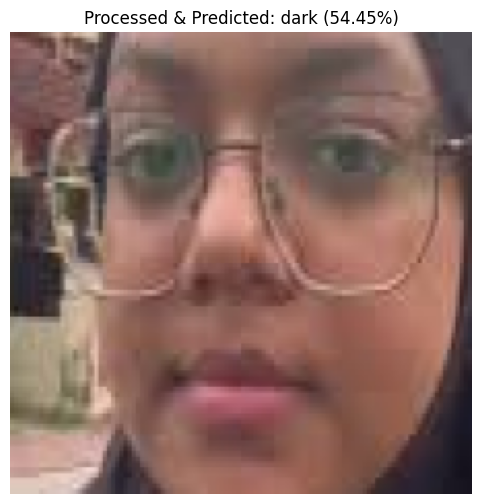


Probabilitas untuk setiap kelas:
  - dark      : 0.5445 (54.45%)
  - light     : 0.0001 (0.01%)
  - mid-dark  : 0.4271 (42.71%)
  - mid-light : 0.0283 (2.83%)
--- Akhir Hasil Prediksi ---
File sementara 'darkskin.jpeg' telah dihapus.


In [85]:
if model is not None and detector is not None:
    print("\n===================================================")
    print(" MEMULAI SESI UNGGAH DAN PREDIKSI GAMBAR BARU ")
    print("===================================================")
    upload_and_predict_colab(model, class_labels, detector, target_size)
else:
    print("\nModel atau Detektor MTCNN tidak berhasil dimuat/diinisialisasi.")
    print("Tidak dapat melanjutkan ke proses unggah dan prediksi.")
    print("Silakan periksa pesan error pada bagian inisialisasi di atas.")